In [368]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [370]:
import pandas as pd

pd.set_option("max_colwidth", 400)

# Download images

In [371]:
from urllib import request
from urllib.error import HTTPError
import os
from tqdm import tqdm_notebook
import time

image_urls = df["thumbnail"]
for url in tqdm_notebook(image_urls):
    image_path = os.path.join("../data/seriouseats/images", url.rsplit("/", 1)[-1])
    if not os.path.isfile(image_path):
        req = request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
        try:
            page = request.urlopen(req)
            with open(image_path, "wb") as f:
                f.write(page.read())
                time.sleep(0.5)
        except Exception as e:
            print(f"Skipping {url} ({e})")

# Preprocess Data

In [372]:
df = pd.read_csv("../data/seriouseats/seriouseats.csv")

In [373]:
df["image_path"] = df["thumbnail"].apply(
    lambda x: os.path.join("../data/seriouseats/images", x.rsplit("/", 1)[-1])
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8312 entries, 0 to 8311
Data columns (total 12 columns):
title                8312 non-null object
short_description    2114 non-null object
thumbnail            8312 non-null object
url                  8312 non-null object
description          7787 non-null object
directions           8282 non-null object
ingredients          8282 non-null object
rating               2898 non-null float64
total_time           5810 non-null object
active_time          6119 non-null object
yields               7518 non-null object
image_path           8312 non-null object
dtypes: float64(1), object(11)
memory usage: 779.3+ KB


### Let's exclude rows where we have no image

In [375]:
df = df[df["image_path"].apply(lambda x: os.path.isfile(x))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8304 entries, 0 to 8311
Data columns (total 12 columns):
title                8304 non-null object
short_description    2114 non-null object
thumbnail            8304 non-null object
url                  8304 non-null object
description          7779 non-null object
directions           8274 non-null object
ingredients          8274 non-null object
rating               2897 non-null float64
total_time           5810 non-null object
active_time          6118 non-null object
yields               7515 non-null object
image_path           8304 non-null object
dtypes: float64(1), object(11)
memory usage: 843.4+ KB


In [376]:
import glob
import random
import base64

from PIL import Image
from io import BytesIO
from IPython.display import HTML

pd.set_option("display.max_colwidth", -1)


def get_thumbnail(path):
    i = Image.open(path).convert("RGB")
    i.thumbnail((224, 224), Image.LANCZOS)
    return i


def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, "jpeg")
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

# Create Embeddings via SqueezeNet

In [378]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [379]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        self.images = df["image_path"].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images.iloc[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image

In [380]:
squeezenet = models.squeezenet1_0(pretrained=True)
set_parameter_requires_grad(squeezenet, True)

In [381]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = model.features
        self.avg_pool2d = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool2d(x)
        x = x.squeeze()
        return x

In [382]:
feature_extractor = FeatureExtractor(squeezenet)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

In [383]:
IMAGE_SIZE = 224

data_transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [385]:
df_images = df[["title", "image_path"]]
dataset = ImageDataset(df_images, data_transforms)
len(dataset)

8304

In [386]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=64, shuffle=False, num_workers=2
)

In [387]:
features = []
for item in tqdm_notebook(dataloader):
    item = item.to(device)
    features.append(feature_extractor(item))

/home/mike/.local/share/virtualenvs/seefood-qNVnXCKQ/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8552 bytes but only got 8356. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag))


In [ ]:
features = torch.cat(features)

In [316]:
features.size()

torch.Size([8304, 512])

In [318]:
from annoy import AnnoyIndex

annoy_index = AnnoyIndex(512)
if os.path.isfile("index_pytorch.ann"):
    annoy_index.load("index_pytorch.ann")
else:
    for i, f in tqdm_notebook(enumerate(features)):
        annoy_index.add_item(i, f)

    annoy_index.build(10000)
    annoy_index.save("index_pytorch.ann")

True

,title,image_path,n_0,n_1,n_2,n_3,n_4
8285,Low Country Boil,,,,,,
698,An Uncommon Apple Tart Featuring Goat Cheese and Rose,,,,,,
6635,Dutch Peanut Sauce for French Fries,,,,,,
7797,Causa (Peruvian Cold Mashed Potato Casserole With Tuna or Chicken),,,,,,
753,A Tofu Throwdown: Lions Head Meatballs vs. Tofu and Orzo,,,,,,
7419,Easy Roasted Brussels Sprouts,,,,,,
684,Jefferson's Crimson,,,,,,
6872,Hummus Kawarma (Lamb) with Lemon Sauce from 'Jerusalem',,,,,,
3446,Cook the Book: Chicken Tingas Sandwich,,,,,,
2931,Slow-Cooker Apple Butter,,,,,,

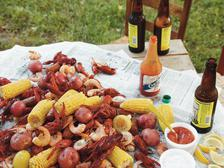
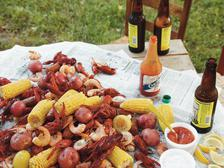
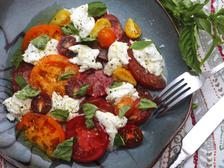
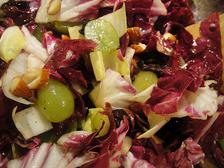
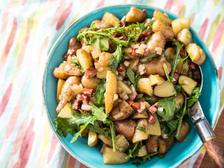
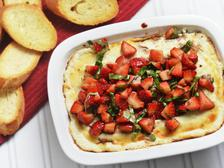
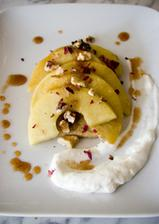
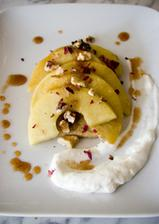
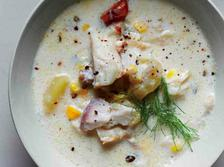
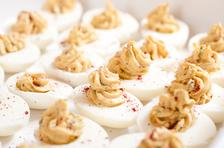
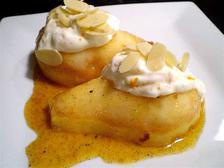
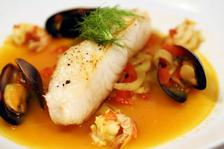
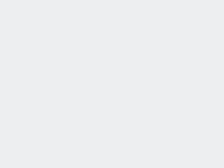
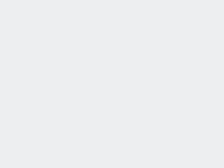
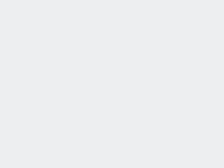
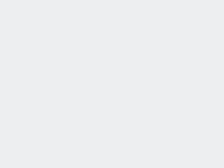
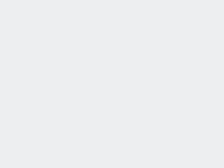
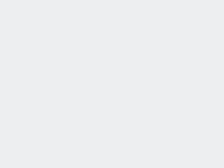
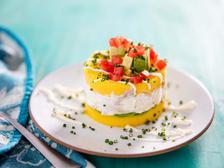
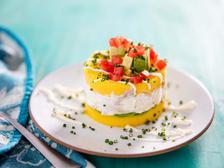
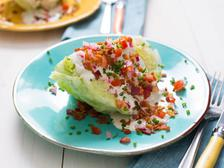
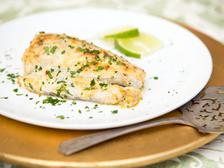
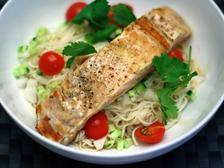
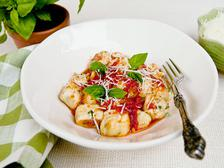
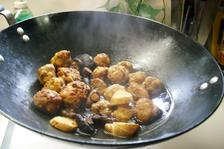
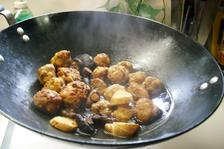
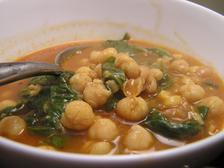
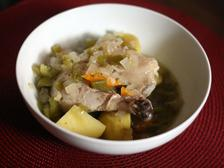
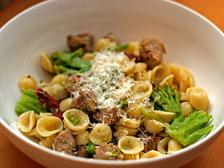
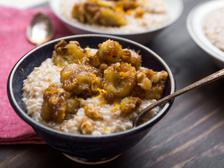
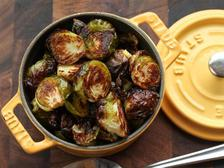
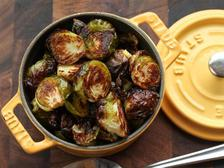
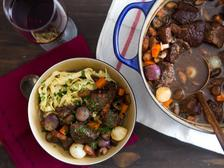
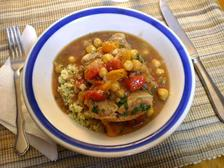
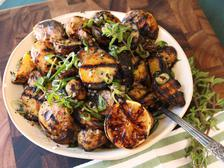
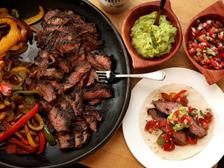
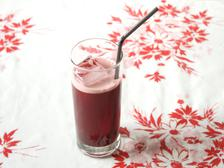
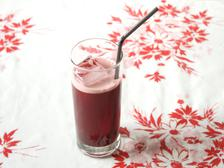
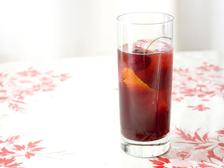
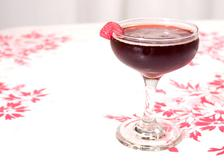
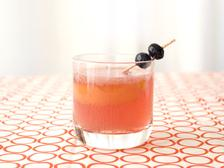
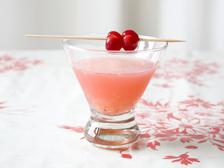
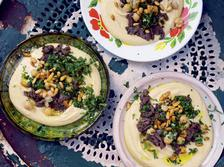
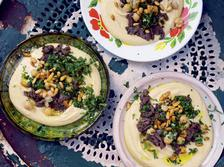
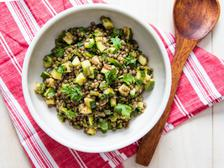
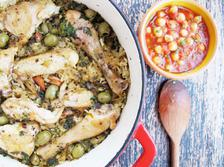
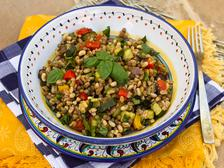
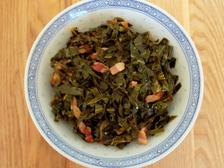
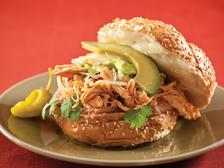
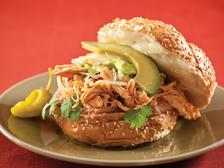
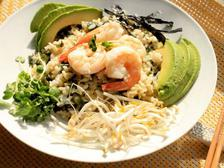
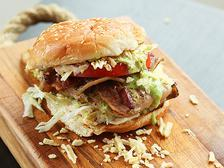
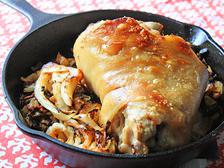
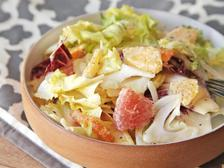
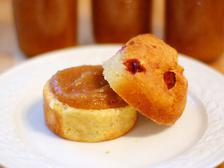
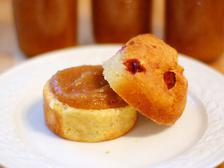
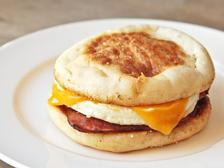
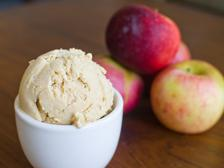
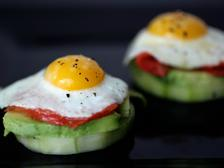
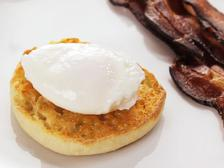
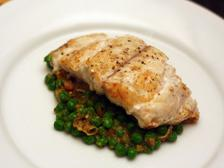
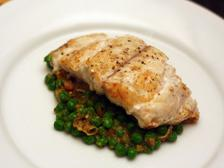
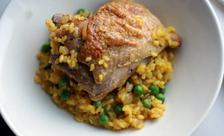
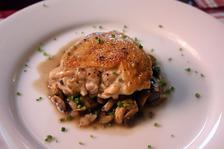
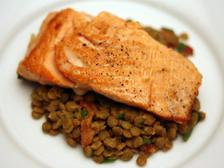
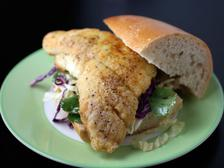
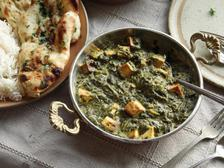
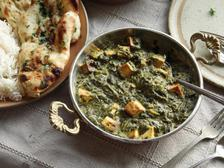
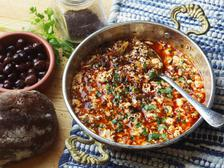
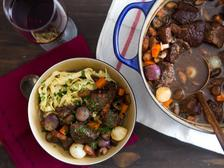
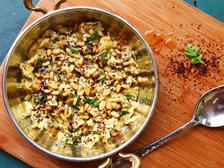
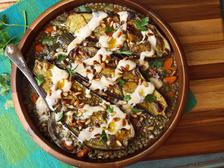
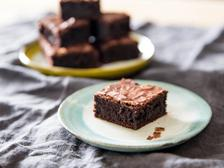
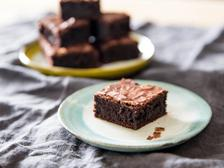
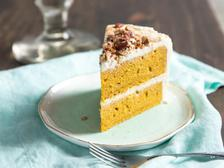
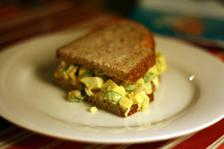
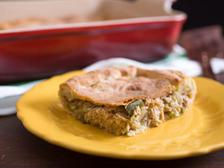
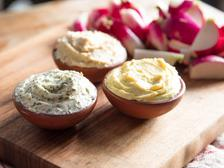
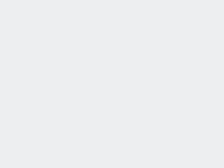
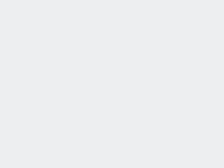
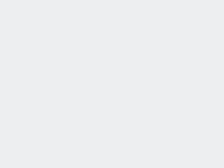
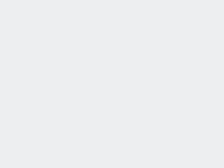
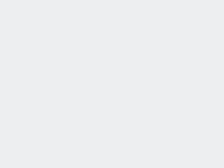
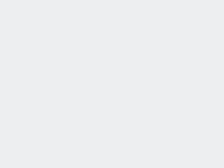
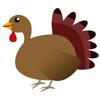
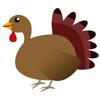
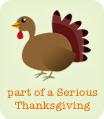
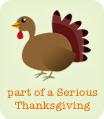
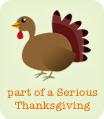
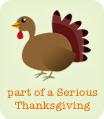
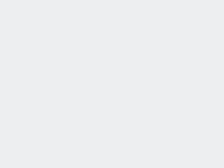
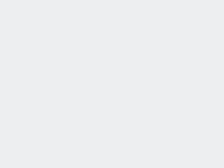
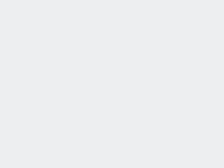
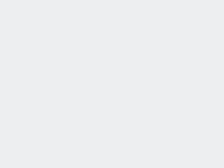
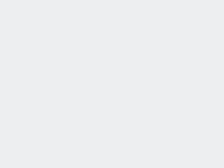
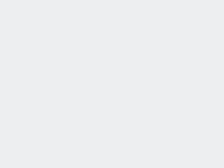
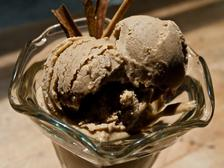
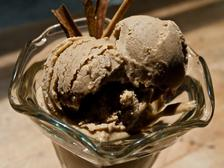
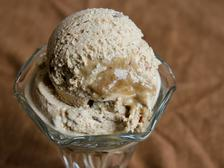
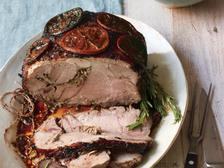
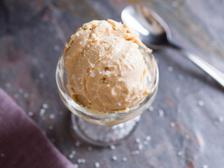
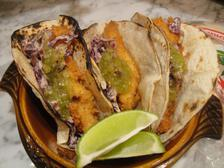
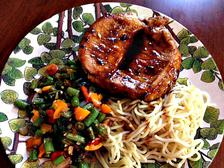
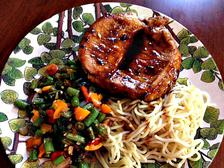
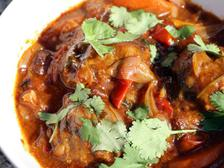
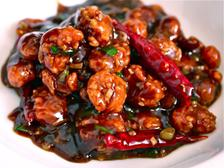
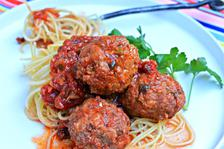
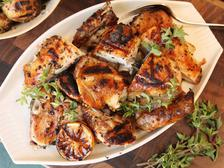
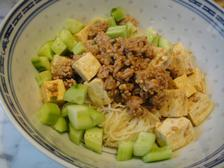
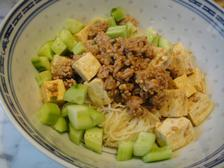
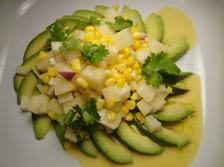
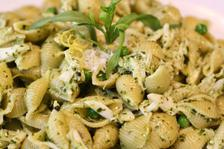
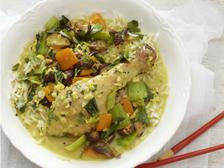
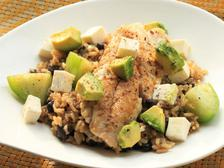
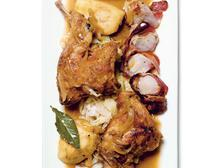
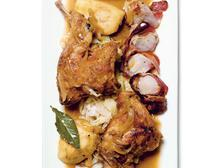
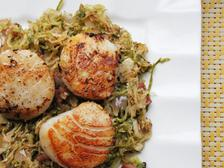
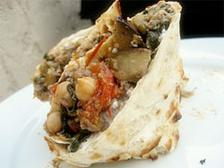
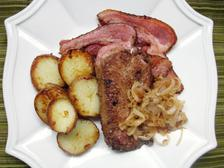
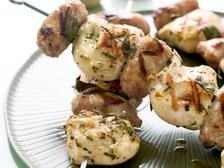
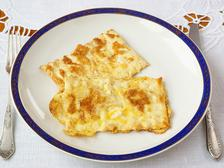
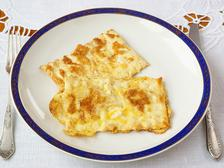
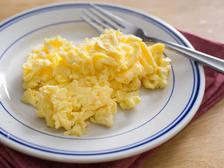
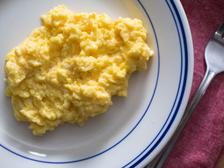
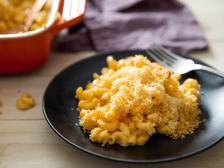
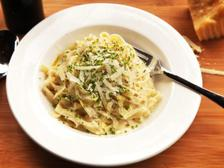
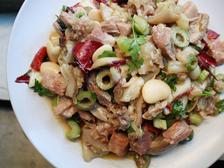
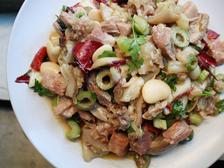
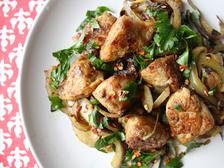
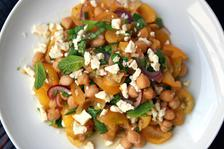
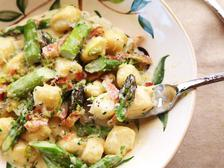
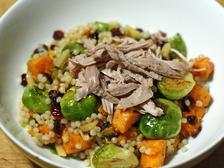
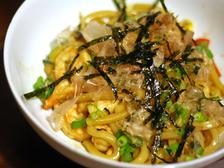
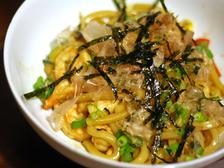
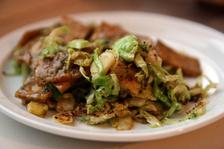
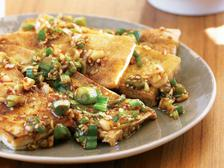
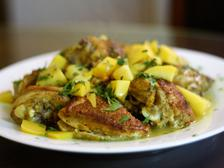
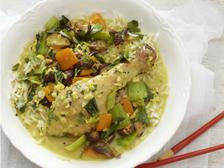
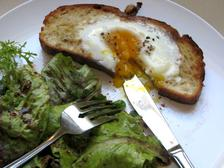
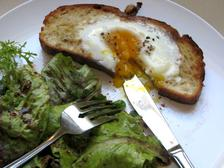
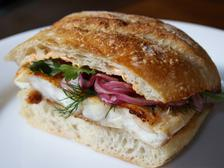
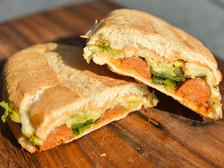
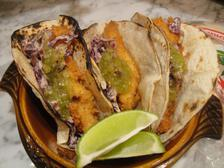
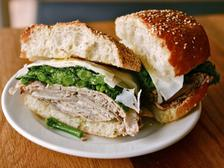
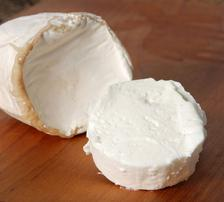
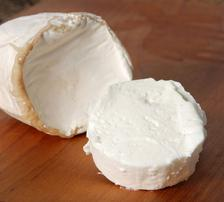
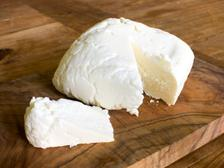
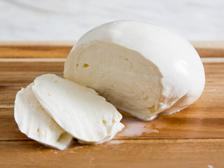
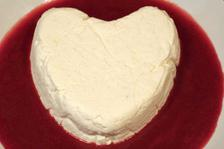
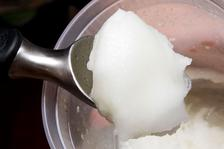
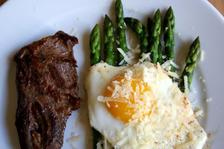
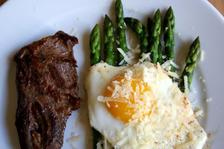
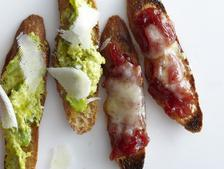
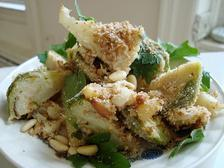
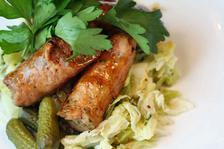
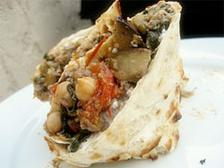
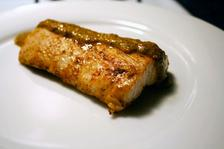
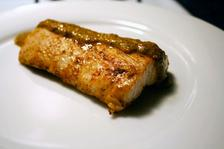
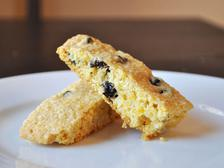
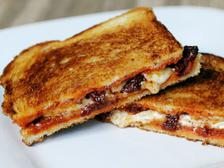
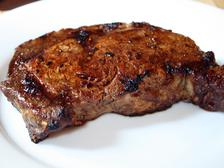
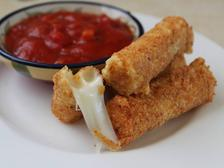
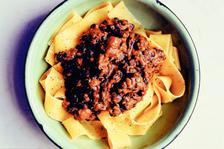
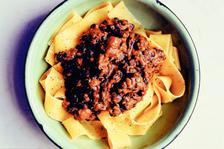
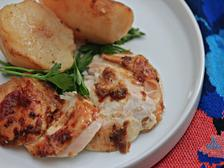
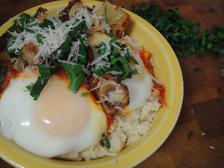
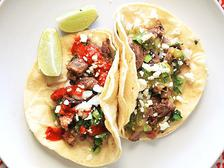
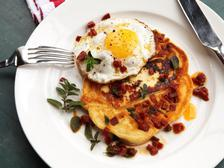
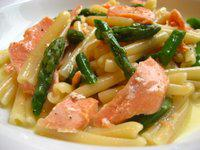
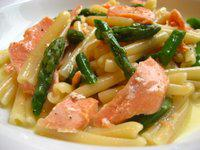
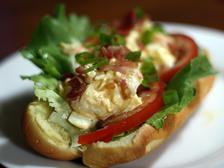
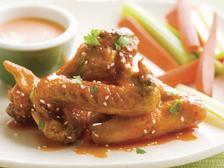
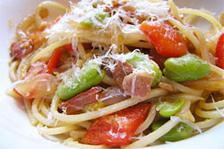
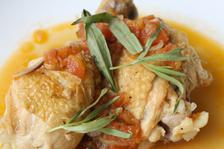
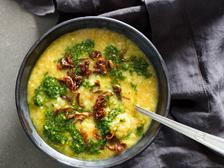
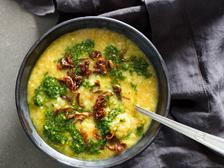
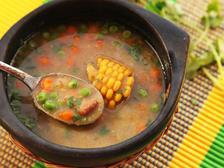
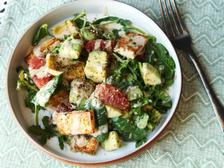
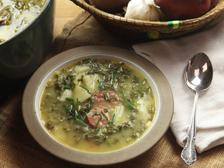
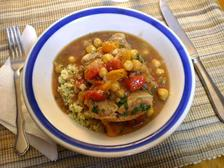

In [359]:
from collections import defaultdict

number_nearest = 5
nearest_cols = defaultdict(list)

df_sample = df_images.sample(30)

for i in df_sample.index.values:
    nearest = annoy_index.get_nns_by_item(df_images.index.get_loc(i), number_nearest)
    for ii, n in enumerate(nearest):
        nearest_cols[ii].append(df_images.iloc[n].image_path)

for key, col in nearest_cols.items():
    df_sample[f"n_{key}"] = col

pd.set_option("display.max_colwidth", -1)
HTML(
    df_sample[
        ["title", "image_path"] + [f"n_{n}" for n in range(number_nearest)]
    ].to_html(
        formatters={
            **{"image_path": image_formatter},
            **{f"n_{n}": image_formatter for n in range(number_nearest)},
        },
        escape=False,
    )
)